In [1]:
import trainer, os
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'c:\\Users\\Hoon\\Nextcloud3\\Projects\\soundClassifier\\soundClassifier'

In [3]:
splited_dataset = trainer.prepare_data('project-1-at-2024-10-14-18-00-93e82746.json')     

  0%|          | 0/107 [00:00<?, ?it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/fbf62549-audio.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


  1%|          | 1/107 [00:07<13:28,  7.63s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/e01cb396-Mcu_done_infusion-error.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\trainer.py:68: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_waveform, sample_rate = librosa.load(path, sr=32000)
c:\Users\Hoon\Nextcloud3\Projects\AudioTrain\.venv\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  2%|▏         | 2/107 [00:08<05:55,  3.38s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/cacf4231-Restart_channel.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


  3%|▎         | 3/107 [00:08<03:31,  2.03s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/df63a5c1-All_alarms.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


  4%|▎         | 4/107 [00:08<02:22,  1.38s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/1a2f5d5f-Bexter__alaris_on.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


  5%|▍         | 5/107 [00:09<01:43,  1.01s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/8fef3952-Alaris_check_iv.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


  6%|▌         | 6/107 [00:09<01:22,  1.23it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/5647ca5c-Alaris_complete.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


  7%|▋         | 7/107 [00:10<01:07,  1.48it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/1a7a93f5-Mcu_keystroke.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


  7%|▋         | 8/107 [00:10<00:56,  1.75it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/a7f71202-Mcu_action_required.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


  8%|▊         | 9/107 [00:10<00:48,  2.03it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/964f6ba7-Baxter_Ba_Battery.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


  9%|▉         | 10/107 [00:11<00:44,  2.18it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/f422ef20-Alaris_air_in_line.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 10%|█         | 11/107 [00:11<00:41,  2.29it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/f429ccd9-Baxter_action_inactive.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 11%|█         | 12/107 [00:11<00:40,  2.32it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/2f3b3b72-Baxters.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 12%|█▏        | 13/107 [00:12<00:50,  1.85it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/0661c7ab-화요일_오전_11-34.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 13%|█▎        | 14/107 [00:13<00:45,  2.04it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/c1f8646d-Room_call_skinner.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 14%|█▍        | 15/107 [00:13<00:42,  2.19it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/ce2bb030-화요일_오전_11-35.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 15%|█▍        | 16/107 [00:13<00:39,  2.32it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/adbb9265-Metal_bed_pan_being_taken_out-metal_clanging.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 16%|█▌        | 17/107 [00:14<00:37,  2.42it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/5218b0d3-Door_opening_and_Closing.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 17%|█▋        | 18/107 [00:14<00:36,  2.43it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/41450de1-Armbubag.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 18%|█▊        | 19/107 [00:15<00:37,  2.35it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/7f1073b7-Bed_adjustment_.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 19%|█▊        | 20/107 [00:15<00:36,  2.35it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/b078d05e-Chair_fight.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 20%|█▉        | 21/107 [00:16<00:41,  2.05it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/d3e8b50a-Curtain.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 21%|██        | 22/107 [00:16<00:40,  2.11it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/ab53cb69-Drawer.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 21%|██▏       | 23/107 [00:17<00:40,  2.10it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/9584abfa-Four_caster_wheeel_hamper.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 22%|██▏       | 24/107 [00:17<00:38,  2.18it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/64de7e7b-Hoyer_actuation.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 23%|██▎       | 25/107 [00:17<00:35,  2.29it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/9b12e9d9-Hoyer_rolling.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 24%|██▍       | 26/107 [00:18<00:35,  2.30it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/94d510af-Medical_air_flow.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 25%|██▌       | 27/107 [00:18<00:35,  2.25it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/105a603b-Metal_cabinet.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 26%|██▌       | 28/107 [00:19<00:34,  2.26it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/f599ee01-Metal_lid_on_glass.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 27%|██▋       | 29/107 [00:19<00:34,  2.28it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/65af6346-Onject_in_glass_bottle.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 28%|██▊       | 30/107 [00:19<00:32,  2.37it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/fee645ed-Pressure_cuff.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 29%|██▉       | 31/107 [00:20<00:31,  2.38it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/91d11ee4-Rolling_chair.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 30%|██▉       | 32/107 [00:21<00:36,  2.08it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/73d2b268-Rolling_spacelabs.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 31%|███       | 33/107 [00:21<00:37,  1.98it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/1474b14f-Sink_hand_washing.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 32%|███▏      | 34/107 [00:22<00:36,  2.00it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/4aa8430b-space_lab_keytone.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 33%|███▎      | 35/107 [00:23<00:48,  1.47it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/1be9fbd1-Stationary_rolling_cart.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 34%|███▎      | 36/107 [00:25<01:32,  1.30s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/ee5b66ef-Trash_bucket.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 35%|███▍      | 37/107 [00:27<01:34,  1.34s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/8694f1fd-Vaccuum_generator.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 36%|███▌      | 38/107 [00:28<01:35,  1.39s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/be4821f0-Velcro.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 36%|███▋      | 39/107 [00:31<02:00,  1.77s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/dbf41d46-금요일_오후_1-05.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 37%|███▋      | 40/107 [00:31<01:32,  1.38s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/ab6d58b5-금요일_오후_1-07.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 38%|███▊      | 41/107 [00:32<01:13,  1.11s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/43a48208-금요일_오후_1-08.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 39%|███▉      | 42/107 [00:33<01:02,  1.04it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/ac584477-금요일_오후_1-10.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 40%|████      | 43/107 [00:33<00:53,  1.20it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/ff9811f6-금요일_오후_1-11.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 41%|████      | 44/107 [00:34<00:46,  1.37it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/f98e01a1-금요일_오후_1-19.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 42%|████▏     | 45/107 [00:34<00:40,  1.54it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/d95e05c6-금요일_오후_1-26.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 43%|████▎     | 46/107 [00:35<00:36,  1.67it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/d8d47ddc-금요일_오후_1-36.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 44%|████▍     | 47/107 [00:35<00:32,  1.84it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/8f957d45-footsteps1.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 45%|████▍     | 48/107 [00:35<00:30,  1.91it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/c158ec3b-footsteps2.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 46%|████▌     | 49/107 [00:36<00:28,  2.01it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/f167d55f-footsteps3.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 47%|████▋     | 50/107 [00:36<00:27,  2.11it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/ca5592d4-footsteps4.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 48%|████▊     | 51/107 [00:37<00:25,  2.18it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/c1cf871c-footsteps5.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 49%|████▊     | 52/107 [00:37<00:23,  2.32it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/2f608a40-footsteps6.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 50%|████▉     | 53/107 [00:38<00:23,  2.30it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/22e6d1d7-footsteps7.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 50%|█████     | 54/107 [00:38<00:25,  2.09it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/04bbd743-footsteps8.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 51%|█████▏    | 55/107 [00:39<00:23,  2.17it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/33b53f09-footsteps9.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 52%|█████▏    | 56/107 [00:39<00:23,  2.21it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/4f591069-footsteps10.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 53%|█████▎    | 57/107 [00:39<00:22,  2.24it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/9fc55f09-alarms1.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 54%|█████▍    | 58/107 [00:40<00:21,  2.32it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/3dd0469e-alarms2.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 55%|█████▌    | 59/107 [00:40<00:20,  2.32it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/b8f86585-alarms3.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 56%|█████▌    | 60/107 [00:41<00:20,  2.32it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/d74aa755-alarms4.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 57%|█████▋    | 61/107 [00:41<00:19,  2.30it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/460ab0e0-alarms5.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 58%|█████▊    | 62/107 [00:42<00:27,  1.62it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/e2dfb383-Drawer_opening_and_closing.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 59%|█████▉    | 63/107 [00:42<00:23,  1.84it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/78ceddb4-427092__nixeno__nixeno-hospital-room-ambience-with-clock-heart-beeb-and-paging.mp3 -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 60%|█████▉    | 64/107 [00:44<00:31,  1.39it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/9231d229-456768__wavjunctioncom__person-pushing-cart-down-hallway.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 61%|██████    | 65/107 [00:46<00:54,  1.31s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/31ac8a28-675561__craigsmith__s05-04-cart-rolling-in-hallway-2-takes.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 62%|██████▏   | 66/107 [00:47<00:50,  1.24s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/a52bdf0f-612621__felixblume__hospital-office-interior-roomtone-with-air-conditi_9wYbr3I.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 63%|██████▎   | 67/107 [00:51<01:20,  2.02s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/1e5f3e4e-62311__erh__808-hospital-vox-2.wav -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 64%|██████▎   | 68/107 [00:52<01:04,  1.65s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/b503ba89-240805-142955.WAV -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 64%|██████▍   | 69/107 [00:54<01:03,  1.67s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/298d654d-240805-143055.WAV -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 65%|██████▌   | 70/107 [00:55<00:56,  1.53s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/782229f3-240801-173521.WAV -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 66%|██████▋   | 71/107 [00:56<00:48,  1.35s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/d78bfc16-240805-141921.WAV -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 67%|██████▋   | 72/107 [00:57<00:41,  1.19s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/41d770f5-240805-141940.WAV -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 68%|██████▊   | 73/107 [01:05<01:49,  3.21s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/10e8e8ab-240805-142321.WAV -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 69%|██████▉   | 74/107 [01:07<01:34,  2.87s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/8c3bb618-240805-142430.WAV -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 70%|███████   | 75/107 [01:09<01:25,  2.67s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/dcdf8e07-240805-142842.WAV -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 71%|███████   | 76/107 [01:12<01:23,  2.69s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/34be1bf2-Onject_in_glass_bottle.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 72%|███████▏  | 77/107 [01:12<01:00,  2.02s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/fd45704e-Pressure_cuff.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 73%|███████▎  | 78/107 [01:12<00:44,  1.54s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/78ba3d17-roomcall.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 74%|███████▍  | 79/107 [01:13<00:34,  1.22s/it]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/7f8488f9-Sink_hand_washing.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 75%|███████▍  | 80/107 [01:13<00:26,  1.01it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/c08deac8-space_lab_keytone.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 76%|███████▌  | 81/107 [01:14<00:21,  1.23it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/37d2f6f5-spacelab4.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 77%|███████▋  | 82/107 [01:14<00:17,  1.40it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/f0886ea4-spacelab5.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 78%|███████▊  | 83/107 [01:15<00:15,  1.60it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/b427ffe7-things_rattling.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 79%|███████▊  | 84/107 [01:15<00:13,  1.75it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/09cd7071-Vaccuum_generator.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 79%|███████▉  | 85/107 [01:16<00:11,  1.90it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/2f50a1fe-Bed_adjustment_.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 80%|████████  | 86/107 [01:16<00:10,  1.99it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/ae863bc9-Curtain.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 81%|████████▏ | 87/107 [01:17<00:11,  1.72it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/37ca6088-Hoyer_actuation.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 82%|████████▏ | 88/107 [01:17<00:10,  1.73it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/003a2dbd-Hoyer_rolling.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 83%|████████▎ | 89/107 [01:18<00:10,  1.80it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/10b23668-Metal_lid_on_glass.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 84%|████████▍ | 90/107 [01:18<00:08,  1.90it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/bdefb059-Rolling_chair.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 85%|████████▌ | 91/107 [01:19<00:08,  1.80it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/cce0d4c9-Rolling_spacelabs.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 86%|████████▌ | 92/107 [01:20<00:08,  1.80it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/03b2dd73-spacelab.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 87%|████████▋ | 93/107 [01:20<00:08,  1.74it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/818b7f0b-spacelab2.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 88%|████████▊ | 94/107 [01:21<00:07,  1.68it/s]

3f84618c-spacelab3.m4a
<class 'IndexError'> trainer.py 66
list index out of range
Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/fd5f463e-Stationary_rolling_cart.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 90%|████████▉ | 96/107 [01:21<00:04,  2.27it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/ffe58c11-Trash_bucket.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 91%|█████████ | 97/107 [01:22<00:04,  2.21it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/adaad522-trolllyy_witth_things.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 92%|█████████▏| 98/107 [01:22<00:04,  2.15it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/9eb45ef5-Velcro.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 93%|█████████▎| 99/107 [01:23<00:03,  2.19it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/236cfa33-Armbubag.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 93%|█████████▎| 100/107 [01:23<00:03,  2.18it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/8ddcc23f-Chair_fight.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 94%|█████████▍| 101/107 [01:24<00:02,  2.20it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/8830abe7-Drawer.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 95%|█████████▌| 102/107 [01:24<00:02,  2.19it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/8a9a36c5-Four_caster_wheeel_hamper.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 96%|█████████▋| 103/107 [01:25<00:01,  2.21it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/657010c4-Medical_air_flow.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 97%|█████████▋| 104/107 [01:25<00:01,  2.13it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/b83f45e6-Metal_cabinet.m4a -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 98%|█████████▊| 105/107 [01:26<00:01,  1.93it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/ca99b189-Alaris_OCCLUSION_COMPLETE_-_KVO.mp3 -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


 99%|█████████▉| 106/107 [01:26<00:00,  1.99it/s]

Retrieving File: /home/worker/.local/share/label-studio/media/upload/1/ce747491-Alaris_RESTART_CHANNEL.mp3 -> c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\dataset


100%|██████████| 107/107 [01:27<00:00,  1.23it/s]


In [4]:
mfcc_features = trainer.get_mfcc(splited_dataset)
mfcc_features = {label: features*2 for label, features in mfcc_features.items()}


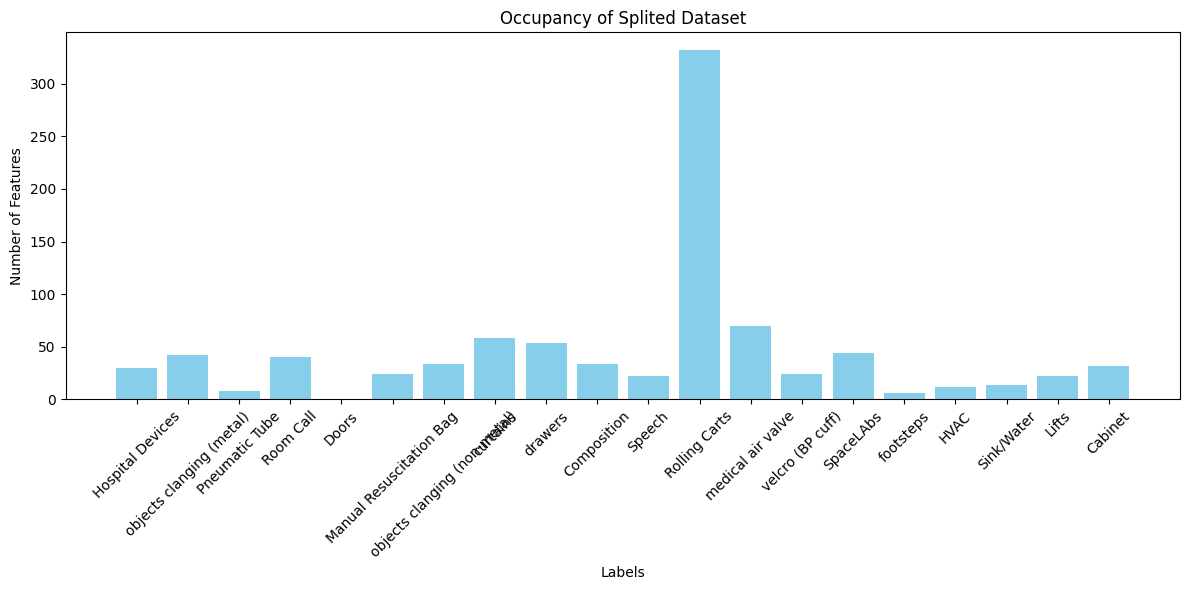

In [5]:
# Visualize the occupancy of the splited dataset
occupancy = {label: len(features) for label, features in mfcc_features.items()}
labels = list(occupancy.keys())
values = list(occupancy.values())

plt.figure(figsize=(12, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Number of Features')
plt.title('Occupancy of Splited Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:

x_train, x_test, y_train, y_test, label = trainer.split_data(mfcc_features)

Training set size: 631
Testing set size: 271


In [7]:
model = trainer.build_model(x_train, x_test, y_train, y_test)

c:\Users\Hoon\Nextcloud3\Projects\AudioTrain\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 40, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 19)             │         9,747 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 383,571 (1.46 MB)

 Trainable params: 383,571 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2444 - loss: 5.4273 - val_accuracy: 0.5978 - val_loss: 1.6691
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5521 - loss: 1.6355 - val_accuracy: 0.6716 - val_loss: 1.1331
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6678 - loss: 1.0944 - val_accuracy: 0.7749 - val_loss: 0.8760
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7543 - loss: 0.8230 - val_accuracy: 0.8745 - val_loss: 0.5215
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8136 - loss: 0.6288 - val_accuracy: 0.8524 - val_loss: 0.5178
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8497 - loss: 0.4811 - val_accuracy: 0.8598 - val_loss: 0.5035
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8818 - loss: 0.3913 - val_accuracy: 0.8303 - val_loss: 0.5692
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8826 - loss: 0.4088 - val_accuracy: 0.8745 - 

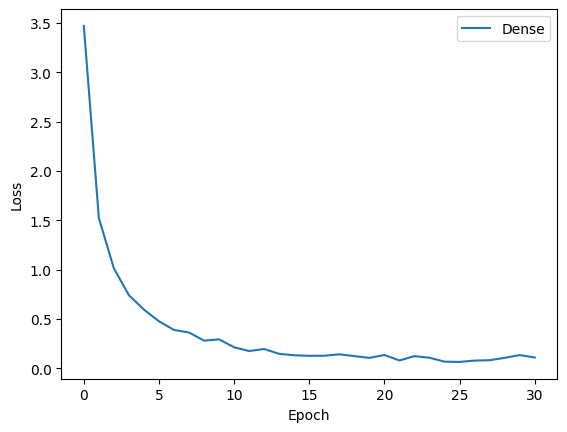

In [8]:

trainer.train(model, x_train, x_test, y_train, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9081 - loss: 0.2670 
Test Loss: 0.2561
Test Accuracy: 0.9041
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
                              precision    recall  f1-score   support

            Hospital Devices       0.62      0.71      0.67         7
    objects clanging (metal)       0.88      1.00      0.93        14
              Pneumatic Tube       1.00      0.60      0.75         5
                   Room Call       1.00      1.00      1.00        10
    Manual Resuscitation Bag       1.00      1.00      1.00         6
objects clanging (non-metal)       1.00      1.00      1.00         6
                    curtains       0.89      1.00      0.94        16
                     drawers       0.73      0.85      0.79        13
                 Composition       1.00      0.76      0.87        17
                      Speech       0.64      1.00      0.78         7
               Rolling Carts       0.98      0.95      0.97       104
          

c:\Users\Hoon\Nextcloud3\Projects\AudioTrain\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hoon\Nextcloud3\Projects\AudioTrain\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hoon\Nextcloud3\Projects\AudioTrain\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

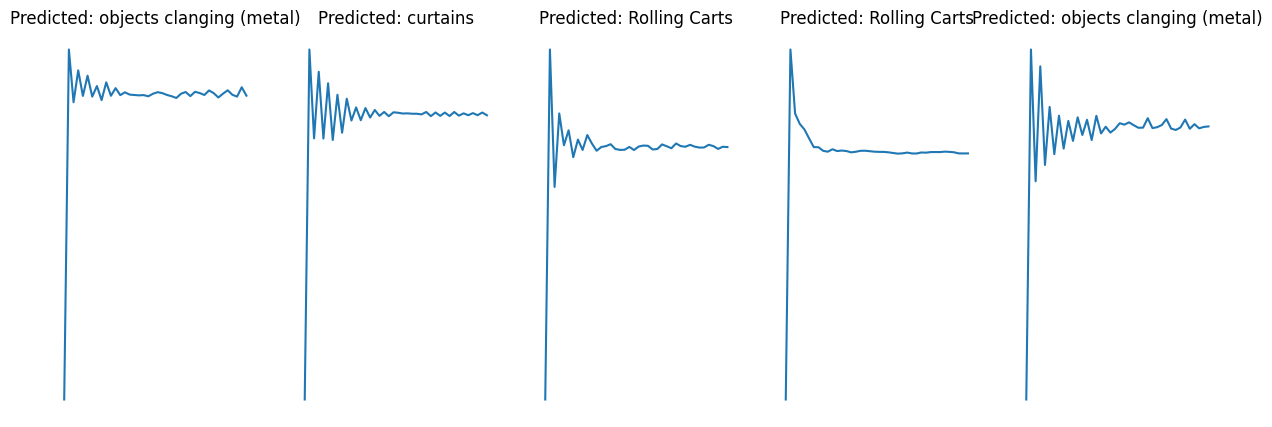

In [9]:
trainer.evaluate(model, x_test, y_test, label)

In [10]:
import tensorflow as tf
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to a .tflite file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\Hoon\AppData\Local\Temp\tmphe10w9u_\assets


INFO:tensorflow:Assets written to: C:\Users\Hoon\AppData\Local\Temp\tmphe10w9u_\assets


Saved artifact at 'C:\Users\Hoon\AppData\Local\Temp\tmphe10w9u_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 19), dtype=tf.float32, name=None)
Captures:
  2906618741504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2906618746432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2906618754704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2909557428768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2909557438624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2909557436688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2909557607056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2909557607936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2909557617792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2909557899680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  29095579081

In [11]:
def predict_labels(x_test, model_path='model.tflite'):
    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Prepare the input data
    x_test_input = np.array([x_test.reshape(1, len(x_test), 1)], dtype=np.float32)
    
    # Set the tensor for the input
    interpreter.set_tensor(input_details[0]['index'], x_test_input[0])

    # Run the model
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Process the output data
    predicted_classes_tflite = np.argmax(output_data, axis=1)[0]
    # Get the labels from the dataset
    
    return predicted_classes_tflite

In [12]:
t = len(x_test)
for x, y in zip(x_test, y_test):
    resx = label[predict_labels(x)]
    resy = label[np.argmax(y)]
    if resx != resy:
        print(resx, ' != ' , resy)
        t -=1

print(t/len(x_test))
 

# 

Hospital Devices  !=  Pneumatic Tube
drawers  !=  Cabinet
Speech  !=  Rolling Carts
curtains  !=  Composition
medical air valve  !=  Sink/Water
Hospital Devices  !=  Rolling Carts
Speech  !=  Rolling Carts
objects clanging (metal)  !=  Rolling Carts
Hospital Devices  !=  Pneumatic Tube
objects clanging (metal)  !=  Rolling Carts
drawers  !=  Cabinet
curtains  !=  Composition
medical air valve  !=  Sink/Water
Speech  !=  Composition
drawers  !=  Cabinet
medical air valve  !=  Sink/Water
Speech  !=  Composition
medical air valve  !=  Sink/Water
HVAC  !=  Hospital Devices
HVAC  !=  Hospital Devices
medical air valve  !=  Sink/Water
drawers  !=  Cabinet
Rolling Carts  !=  drawers
medical air valve  !=  Sink/Water
Rolling Carts  !=  drawers
medical air valve  !=  Sink/Water
0.9040590405904059


In [13]:
model.save('model.h5')


In [14]:
from keras.models import load_model

# Load the model
model = load_model('model.h5')

# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Make predictions
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Generate a classification report
from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_classes, target_names=[label[i] for i in np.unique(true_classes)])
print(report)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9081 - loss: 0.2670
Test Loss: 0.25605320930480957, Test Accuracy: 0.9040590524673462
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
                              precision    recall  f1-score   support

            Hospital Devices       0.62      0.71      0.67         7
    objects clanging (metal)       0.88      1.00      0.93        14
              Pneumatic Tube       1.00      0.60      0.75         5
                   Room Call       1.00      1.00      1.00        10
    Manual Resuscitation Bag       1.00      1.00      1.00         6
objects clanging (non-metal)       1.00      1.00      1.00         6
                    curtains       0.89      1.00      0.94        16
                     drawers       0.73      0.85      0.79        13
                 Composition       1.00      0.76      0.87        17
                      Speech       0.64      1.00      0.78         7
               Rolling Carts       0.98      0.95      

c:\Users\Hoon\Nextcloud3\Projects\AudioTrain\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hoon\Nextcloud3\Projects\AudioTrain\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hoon\Nextcloud3\Projects\AudioTrain\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m